In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
import numpy as np
import pandas as pd

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1,))])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the Encoder class
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.bn1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.bn2(x)

        x = self.conv3(x)
        x = self.relu(x)

        return x


# Modify the Decoder to include dropout
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv1 = nn.ConvTranspose2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv1 = nn.ConvTranspose2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.bn1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.bn2(x)

        x = self.conv3(x)
        x = self.relu(x)

        return x



# Combine Encoder and Decoder into an Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
# Initialize autoencoder model, criterion, and optimizer
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
num_epochs = 10

train_losses = []

In [ ]:
%%time
start_time = time.time()

epochs_iterator = tqdm(range(num_epochs), desc='Epochs')
for epoch in epochs_iterator:
    autoencoder.train()
    running_loss = 0.0

    data_iterator = tqdm(enumerate(train_loader), desc='Batches', total=len(train_loader), leave=False)

    for batch_idx, (data, _) in data_iterator:
        data = data.to(device)

        optimizer.zero_grad()
        outputs = autoencoder(data)
        loss = criterion(outputs, data)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        data_iterator.set_description(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.5f}')

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.5f}')
    scheduler.step()

end_time = time.time()

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.03428


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [2/10], Loss: 0.01211


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [3/10], Loss: 0.00957


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [4/10], Loss: 0.00826


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [5/10], Loss: 0.00808


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [6/10], Loss: 0.00793


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [7/10], Loss: 0.00771


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [8/10], Loss: 0.00768


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [9/10], Loss: 0.00766


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [10/10], Loss: 0.00764
CPU times: user 3min 10s, sys: 3.34 s, total: 3min 14s
Wall time: 3min 27s


In [ ]:
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")

Training Time: 207.38 seconds


torch.Size([64, 1, 7, 7])


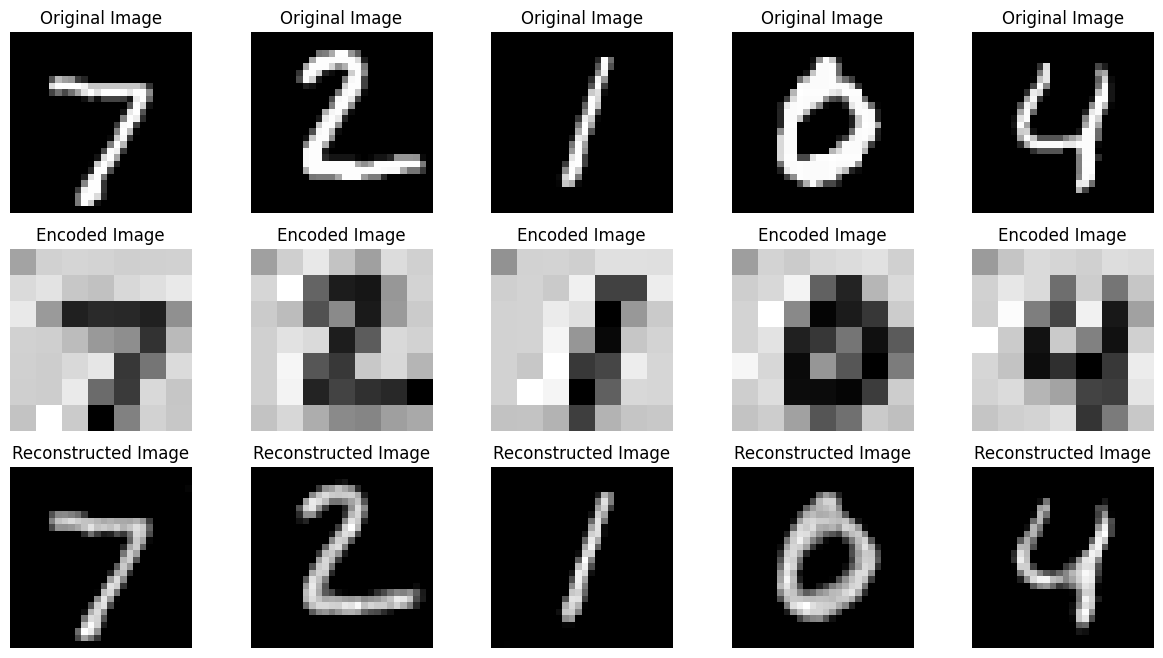

In [ ]:
# Test the autoencoder
autoencoder.eval()
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        reconstructed = autoencoder(data)
        encoded = autoencoder.encoder(data)
        print(encoded.size())
        break

# Plot the original, encoded, and reconstructed images
n = 5
plt.figure(figsize=(15, 8))

for i in range(n):
    # Original images
    plt.subplot(3, n, i + 1)
    plt.imshow(data[i][0].cpu().numpy(), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Encoded images
    plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded[i][0].cpu().numpy(), cmap='gray')
    plt.title('Encoded Image')
    plt.axis('off')

    # Reconstructed images
    plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(reconstructed[i][0].cpu().numpy(), cmap='gray')
    plt.title('Reconstructed Image')
    plt.axis('off')

plt.show()


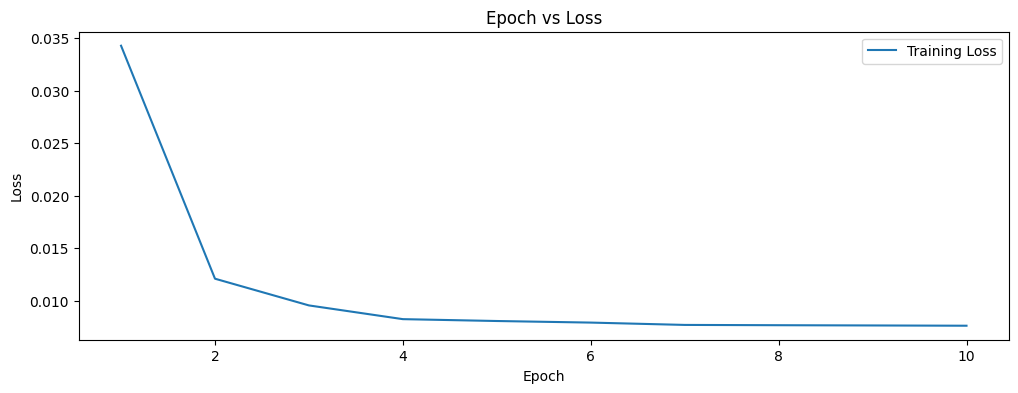

In [ ]:
# Plotting
plt.figure(figsize=(12, 4))

# Plotting Loss

plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.show()

In [ ]:
# Create DataFrames for train and test data
train_embeddings = []
train_labels = []

test_embeddings = []
test_labels = []

autoencoder.eval()  # Set the autoencoder to evaluation mode

# Generate embeddings for train data
with torch.no_grad():
    for data, labels in train_loader:
        data = data.to(device)
        embeddings = autoencoder.encoder(data).view(data.size(0), -1).cpu().numpy()  # Flatten the embeddings
        train_embeddings.append(embeddings)
        train_labels.extend(labels.numpy())

# Generate embeddings for test data
with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(device)
        embeddings = autoencoder.encoder(data).view(data.size(0), -1).cpu().numpy()  # Flatten the embeddings
        test_embeddings.append(embeddings)
        test_labels.extend(labels.numpy())

# Flatten and concatenate the embeddings
train_embeddings = np.concatenate(train_embeddings, axis=0)
test_embeddings = np.concatenate(test_embeddings, axis=0)

# Create DataFrames
train_df = pd.DataFrame(data=np.column_stack((train_embeddings, train_labels)), columns=[f"feat_{i}" for i in range(train_embeddings.shape[1])] + ["label"])
test_df = pd.DataFrame(data=np.column_stack((test_embeddings, test_labels)), columns=[f"feat_{i}" for i in range(test_embeddings.shape[1])] + ["label"])

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        features = self.dataframe.iloc[idx, :-1].values.astype(np.float32)
        label = self.dataframe.iloc[idx, -1].astype(int)
        return torch.tensor(features), torch.tensor(label)

# Create datasets
train_dataset = CustomDataset(train_df)
test_dataset = CustomDataset(test_df)

# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the Classifier model
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.25):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
input_size = 49
hidden_size = 128
output_size = 10
dropout_rate = 0.25
learning_rate = 0.001
num_epochs = 10

# Initialize the classifier model, criterion, and optimizer
classifier = Classifier(input_size, hidden_size, output_size, dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [ ]:
%%time
# Training loop
epochs_iterator = tqdm(range(num_epochs), desc='Epochs')
for epoch in epochs_iterator:
    classifier.train()
    running_loss = 0.0
    correct = 0
    total = 0

    data_iterator = tqdm(enumerate(train_loader), desc='Batches', total=len(train_loader), leave=False)

    for batch_idx, (data, labels) in data_iterator:
        data, labels = data.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = classifier(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        data_iterator.set_description(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.5f}')

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.5f}, Accuracy: {epoch_acc:.2f}%')

    # Evaluation on the test set
    classifier.eval()
    correct = 0
    total = 0
    test_loss = 0.0

    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.view(data.size(0), -1).to(device), targets.to(device)
            outputs = classifier(data)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            test_loss += criterion(outputs, targets).item()

    test_acc = 100 * correct / total
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_acc)
    print(f'Test Accuracy: {test_acc:.2f}%')

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.77046, Accuracy: 77.47%
Test Accuracy: 89.60%


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [2/10], Loss: 0.40114, Accuracy: 87.48%
Test Accuracy: 91.51%


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [3/10], Loss: 0.33834, Accuracy: 89.47%
Test Accuracy: 92.51%


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [4/10], Loss: 0.29655, Accuracy: 90.90%
Test Accuracy: 93.54%


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [5/10], Loss: 0.26541, Accuracy: 91.85%
Test Accuracy: 94.18%


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [6/10], Loss: 0.24907, Accuracy: 92.33%
Test Accuracy: 94.68%


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [7/10], Loss: 0.22949, Accuracy: 92.89%
Test Accuracy: 95.30%


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [8/10], Loss: 0.21716, Accuracy: 93.36%
Test Accuracy: 95.31%


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [9/10], Loss: 0.20678, Accuracy: 93.60%
Test Accuracy: 95.54%


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [10/10], Loss: 0.19963, Accuracy: 93.84%
Test Accuracy: 95.79%
CPU times: user 2min 39s, sys: 3.23 s, total: 2min 43s
Wall time: 2min 52s


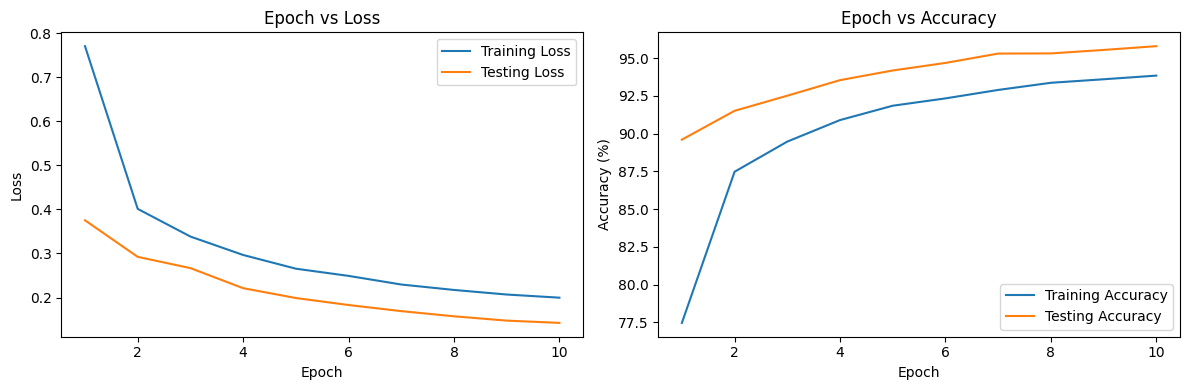

In [ ]:
# Plotting
plt.figure(figsize=(12, 4))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Epoch vs Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
predicted_labels = []
true_labels = []

classifier.eval()
with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = classifier(data)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(targets.cpu().numpy())


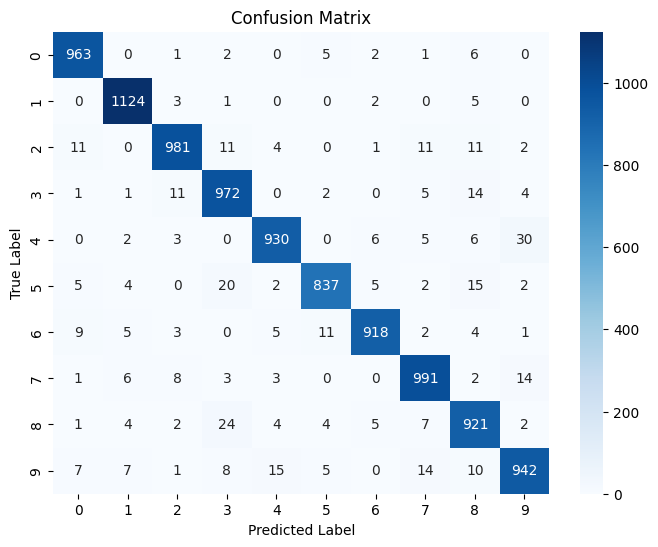

In [ ]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
classification_rep = classification_report(true_labels, predicted_labels)
print("\nClassification Report:")
print(classification_rep)


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.97      0.99      0.98      1135
           2       0.97      0.95      0.96      1032
           3       0.93      0.96      0.95      1010
           4       0.97      0.95      0.96       982
           5       0.97      0.94      0.95       892
           6       0.98      0.96      0.97       958
           7       0.95      0.96      0.96      1028
           8       0.93      0.95      0.94       974
           9       0.94      0.93      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



In [ ]:
es = accuracy_score(true_labels, predicted_labels)

# Calculate the margin of error
margin_of_error = 1.96 * np.sqrt(es * (1 - es) / len(true_labels))

# Calculate the confidence interval
confidence_interval = (es - margin_of_error, es + margin_of_error)

print(f"95% Confidence Interval: {confidence_interval}")


95% Confidence Interval: (0.9539639808213881, 0.9618360191786118)
